In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [11]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

## 1.数据预处理

### 1.1导入数据

In [75]:
data = pd.read_csv('./data.csv', encoding='ISO-8859-1', encoding_errors='ignore', 
                   dtype={'CustomerID' : str, 'InvoiceNo':str})
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


### 1.2 数据预处理

查看数据的缺失情况

In [53]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

CustomerID缺失非常严重 : 24.9%

In [54]:
data['CustomerID'].isnull().sum() / data.shape[0]

0.249266943342886

初步观察Description是NaN时 UnitPrice是0 CustomerID也是NaN 这不太合理 是否能说明这是噪声数据

In [55]:
data.loc[data['Description'].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


In [56]:
len(data.loc[(data['Description'].isna()) & (data['UnitPrice'] == 0)])

1454

推断是成立的 这是脏数据 可以删除

In [76]:
len(data.loc[(data['Description'].isna()) & (data['CustomerID'].isna())])

1454

但是描述仍有可能为空串、nan

In [79]:
data.loc[data.Description.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.Description.isnull()==False,"Description"
].apply(lambda l: l.lower())

data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

lowercase_descriptions
False    539724
True        731
Name: count, dtype: int64

In [80]:
data.loc[data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"
].apply(lambda l: np.where("nan" in l, None, l))

#### 仅保留所有都不为空的数据

In [81]:
data = data.loc[(data['Description'].isna() == False) & 
                (data['lowercase_descriptions'].isna() == False) &
                (data['CustomerID'].isna() == False)
                ].copy()

In [26]:
data.isnull().sum()

InvoiceNo                 0
StockCode                 0
Description               0
Quantity                  0
InvoiceDate               0
UnitPrice                 0
CustomerID                0
Country                   0
lowercase_descriptions    0
dtype: int64

## 2.探索数据集

### 2.1 探索StockCode

##### 共有多少种产品

In [66]:
data['StockCode'] = data['StockCode'].str.upper()
data['StockCode'].nunique() #3682种产品

3682

##### 展示出现频率最高的前20个产品

POST是什么产品的编码？？

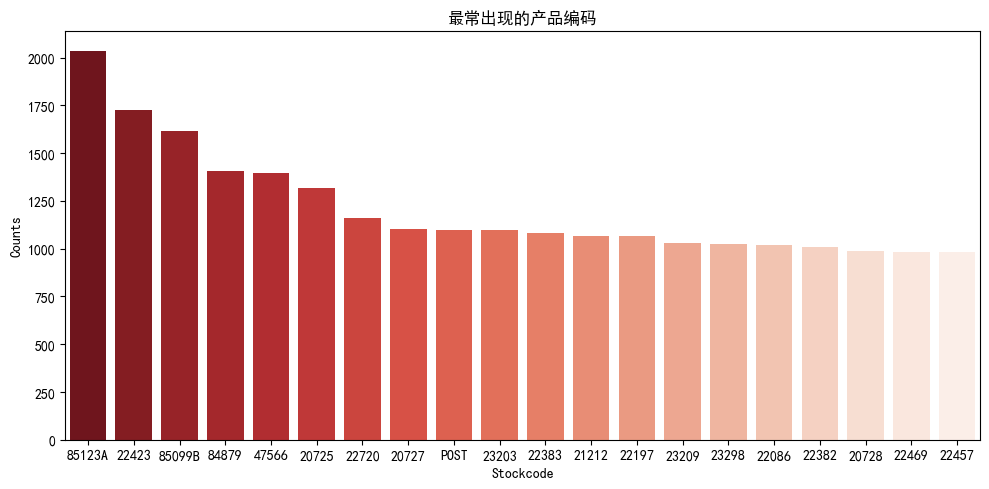

In [5]:
stockcode_counts = data.StockCode.value_counts().sort_values(ascending=False)
plt.subplots(1,1,figsize=(10,5))
sns.barplot(x=stockcode_counts.iloc[0:20].index,
            y=stockcode_counts.iloc[0:20].values,
            palette="Reds_r")
plt.ylabel("Counts")
plt.xlabel("Stockcode")
plt.title("最常出现的产品编码")
plt.tight_layout()

编码长度的分布

主要集中在5 也有部分集中在6

Text(0.5, 1.0, '编码的长度分布')

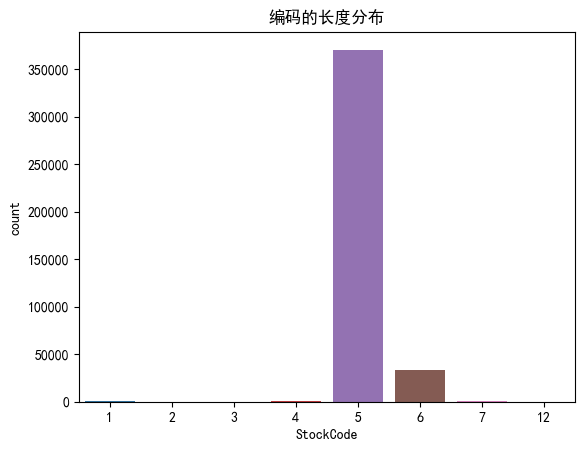

In [106]:
len_of_stockcodes = data['StockCode'].str.len()
sns.countplot(x=len_of_stockcodes)
plt.title('编码的长度分布')

编码中包含多少位数字

Text(0.5, 1.0, 'StockCode中数字的个数')

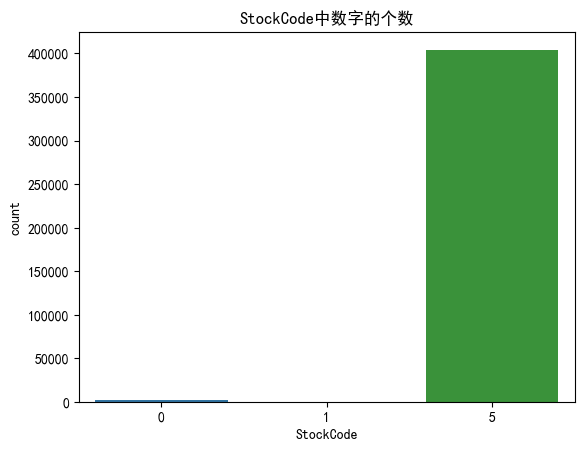

In [113]:
def fun(l):
    return sum(1 for c in l if c.isdigit())

stockcode_is_digit = data.StockCode.apply(fun)
sns.countplot(x=stockcode_is_digit)
plt.title('StockCode中数字的个数')

stockcode以哪些数字开头

<Axes: xlabel='StockCode', ylabel='count'>

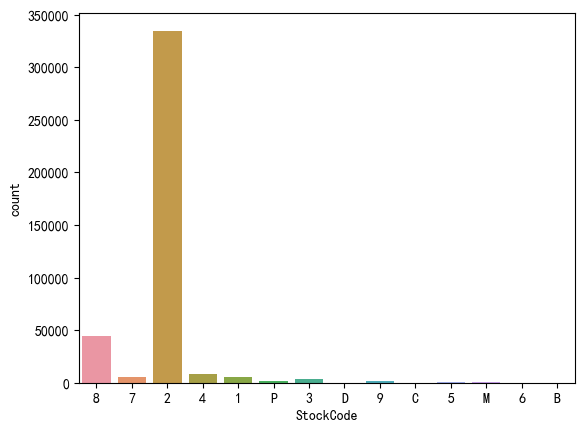

In [116]:
stockcode_startword = data.StockCode.apply(lambda x : x[0])
sns.countplot(x=stockcode_startword)

In [9]:
data.loc[data['StockCode'].str[0] == 'C']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1412,536540,C2,carriage,1,2010-12-01 14:05:00,50.0,14911,EIRE
8507,537368,C2,carriage,1,2010-12-06 12:40:00,50.0,14911,EIRE
8839,537378,C2,carriage,1,2010-12-06 13:06:00,50.0,14911,EIRE
13093,537963,C2,carriage,1,2010-12-09 11:30:00,50.0,13369,United Kingdom
13130,538002,C2,carriage,1,2010-12-09 11:48:00,50.0,14932,Channel Islands
...,...,...,...,...,...,...,...,...
378199,579539,C2,carriage,1,2011-11-30 10:06:00,50.0,14911,EIRE
379564,579768,C2,carriage,1,2011-11-30 15:08:00,50.0,14911,EIRE
380108,579910,C2,carriage,1,2011-12-01 08:52:00,50.0,14911,EIRE
381810,580127,C2,carriage,1,2011-12-01 17:51:00,50.0,14911,EIRE


字母表示：  
P:POST  
D:DOT  
C:C2、CRUK(carriage)  
M:M(manual)  
B:BANK CHARGES  

### 2.2 地区分布

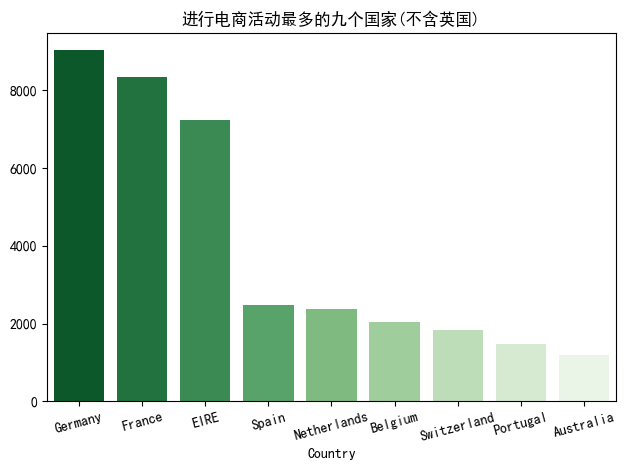

In [71]:
country_top10 = data.Country.value_counts().sort_values(ascending=False)
plt.title("进行电商活动最多的九个国家(不含英国)")
sns.barplot(x=country_top10.iloc[1:10].index,y=country_top10.iloc[1:10].values,palette='Greens_r')
plt.xticks(rotation=15)
plt.tight_layout()

### 2.3 Quantity属性的探索

In [213]:
data['Description'] = data['Description'].str.lower()

为负数的共同点：发票号C开头


我想查找描述只包含单个单词的信息

In [82]:
# Quantity为什么可以为负数
data_quantity_is_negetive = data.loc[data['Quantity'] < 0]
Description = data_quantity_is_negetive['Description'].tolist()

In [83]:
only_one = []
for des in Description:
    des = str(des)
    if len(des.split(' ')) == 1:
        only_one.append(des)
only_one

['Discount',
 'Discount',
 'POSTAGE',
 'Discount',
 'Discount',
 'Manual',
 'Manual',
 'Discount',
 'Discount',
 'Discount',
 'POSTAGE',
 'POSTAGE',
 'POSTAGE',
 'Discount',
 'POSTAGE',
 'POSTAGE',
 'CARRIAGE',
 'Discount',
 'Manual',
 'Manual',
 'POSTAGE',
 'POSTAGE',
 'POSTAGE',
 'POSTAGE',
 'Manual',
 'Manual',
 'Manual',
 'Manual',
 'Manual',
 'POSTAGE',
 'POSTAGE',
 'POSTAGE',
 'Manual',
 'Manual',
 'Manual',
 'Discount',
 'Discount',
 'Manual',
 'Discount',
 'Manual',
 'Manual',
 'POSTAGE',
 'Discount',
 'Manual',
 'POSTAGE',
 'POSTAGE',
 'Manual',
 'Manual',
 'Manual',
 'Manual',
 'Manual',
 'Manual',
 'Discount',
 'Discount',
 'Manual',
 'Manual',
 'Manual',
 'POSTAGE',
 'Manual',
 'Manual',
 'Discount',
 'POSTAGE',
 'POSTAGE',
 'POSTAGE',
 'Manual',
 'Manual',
 'POSTAGE',
 'Manual',
 'Manual',
 'Manual',
 'Manual',
 'Manual',
 'Manual',
 'POSTAGE',
 'POSTAGE',
 'Discount',
 'Manual',
 'Manual',
 'Manual',
 'Manual',
 'Manual',
 'Discount',
 'Manual',
 'Manual',
 'Manual',
 'Ma

Text(0.5, 1.0, 'Quantity为负数时描述(Description)中仅有一个单词的数据类型和分布情况')

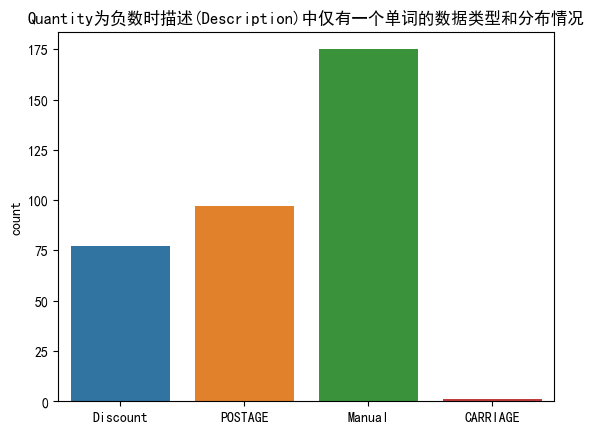

In [84]:
sns.countplot(x=only_one)
plt.title('Quantity为负数时描述(Description)中仅有一个单词的数据类型和分布情况')

对数据进行观察后发现，描述为discount时数量都是负数  
其他属性均有正有负

在进行用户画像分析时 这些数据并不是由用户购买活动直接产生的  
因此我认为 在最后的分类中可以不考虑这些数据

In [157]:
data.loc[data['Description'] == 'postage'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,lowercase_descriptions
45,536370,POST,postage,3,12/1/2010 8:45,18.0,12583,France,postage
386,536403,POST,postage,1,12/1/2010 11:27,15.0,12791,Netherlands,postage
1123,536527,POST,postage,1,12/1/2010 13:04,18.0,12662,Germany,postage
5073,536840,POST,postage,1,12/2/2010 18:27,18.0,12738,Germany,postage
5258,536852,POST,postage,1,12/3/2010 9:51,18.0,12686,France,postage


In [216]:
data.drop(columns='lowercase_descriptions',inplace=True) # 新加入的辅助属性删掉

1


除了上述情况以外 剩余的数量为负的数据应该是用户取消订单产生的  
因此 现在的目标是 找出同一顾客在取消订单之前下的但 并将其与取消订单的数据统统  
从数据中删除 得到clean_data

In [164]:
data.loc[data['InvoiceNo'].str[0] == 'C'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
154,C536383,35004C,set of 3 coloured flying ducks,-1,12/1/2010 9:49,4.65,15311,United Kingdom
235,C536391,22556,plasters in tin circus parade,-12,12/1/2010 10:24,1.65,17548,United Kingdom
236,C536391,21984,pack of 12 pink paisley tissues,-24,12/1/2010 10:24,0.29,17548,United Kingdom
237,C536391,21983,pack of 12 blue paisley tissues,-24,12/1/2010 10:24,0.29,17548,United Kingdom


In [217]:
data.iloc[10,:].CustomerID

'13047'

发票日期转为datetime格式

In [182]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [218]:
# StockCode CustomerID InvoiceDate
doubtfull_entry = []
entry_to_remove = []

df_cleaned = data.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

for index, col in data_quantity_is_negetive.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue

    df_test = data[(data['CustomerID'] == col['CustomerID']) &
                         (data['StockCode']  == col['StockCode']) & 
                         (data['InvoiceDate'] < col['InvoiceDate']) & 
                         (data['Quantity'] == -col['Quantity'])].copy()

    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    
    else:
        continue

entry_to_remove

[6782,
 8685,
 8952,
 9493,
 11799,
 12455,
 12946,
 12947,
 12948,
 12949,
 12950,
 12951,
 13009,
 13010,
 13011,
 13012,
 13019,
 13020,
 13042,
 14497,
 14717,
 17134,
 18235,
 19350,
 19391,
 21657,
 21700,
 21719,
 24159,
 24160,
 24166,
 24170,
 24171,
 24172,
 24173,
 24179,
 24180,
 24184,
 24214,
 25208,
 25554,
 26055,
 26149,
 28607,
 29064,
 29254,
 29256,
 29281,
 29436,
 29529,
 30972,
 30973,
 30974,
 31004,
 31019,
 31075,
 31935,
 31938,
 32382,
 32385,
 32391,
 32870,
 33085,
 33086,
 33254,
 33396,
 33613,
 33630,
 33635,
 33699,
 33700,
 34291,
 34292,
 36165,
 36301,
 38417,
 38439,
 38444,
 38445,
 38446,
 38447,
 38448,
 38449,
 38450,
 38451,
 38452,
 38453,
 38454,
 38455,
 38456,
 38457,
 38458,
 38459,
 38460,
 38461,
 38940,
 38944,
 39318,
 39319,
 39380,
 39636,
 39638,
 39900,
 39904,
 41619,
 41623,
 42557,
 42559,
 42560,
 43331,
 43559,
 43664,
 43783,
 44307,
 44308,
 44311,
 46770,
 46771,
 46881,
 46882,
 47125,
 47165,
 47242,
 47470,
 47471,
 474

将index在entry_to_remove和quantity_is_negtive中的数据删掉

In [236]:
t = data.loc[~(data.index.isin(entry_to_remove))] #403978
t = data.loc[~data.index.isin(data_quantity_is_negetive.index)] #397327
data = t

In [239]:
data.to_csv('./data_cleaned.csv',index=False)

推测取消订单仅比原订单在发票号上多了C 假设不成立

In [175]:
clean_InvoiceNo = data_quantity_is_negetive.InvoiceNo.str[1:].to_list() # 8896 3651 有重复数据
data.loc[data['InvoiceNo'].isin(clean_InvoiceNo)]
data.loc[data['InvoiceNo'] == '536391']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


### 2.4 对UnitPrice进行探索

想法：以同一发票号、同一用户id、同一StockCode为分类依据进行分类  
目的是查找出该用户某一笔交易对某一种产品的购买金额

In [4]:
data = pd.read_csv('./data_cleaned.csv')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
397322,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,France
397323,581587,22899,children's apron dolly girl,6,2011-12-09 12:50:00,2.10,12680,France
397324,581587,23254,childrens cutlery dolly girl,4,2011-12-09 12:50:00,4.15,12680,France
397325,581587,23255,childrens cutlery circus parade,4,2011-12-09 12:50:00,4.15,12680,France


新增属性totalPrice

In [7]:
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


#### 根据totalprice进行分类

In [13]:
data['TotalPrice'].describe()

count    397327.000000
mean         22.401355
std         309.286588
min           0.000000
25%           4.680000
50%          11.800000
75%          19.800000
max      168469.600000
Name: TotalPrice, dtype: float64

根据人们常使用的价格区间对产品进行分类  
'0-5'  
'5-20'  
'20-50'  
'50-150'  
'150及以上'

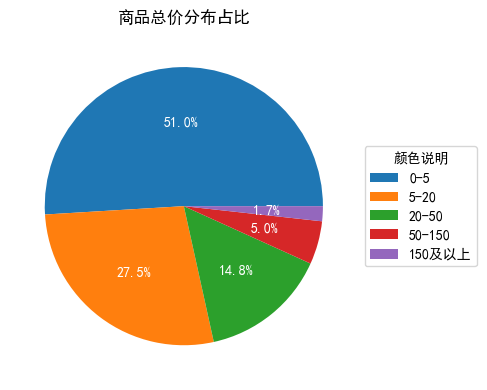

In [8]:
bins = [0,5,20,50,150,168470]
label = ['0-5','5-20','20-50','50-150','150及以上']

cut = pd.cut(data['TotalPrice'],bins=bins,labels=label)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%"

fig, ax = plt.subplots(figsize=(6, 4), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = plt.pie(x=cut.value_counts().values,autopct=lambda pct: func(pct, cut.value_counts().values),
        textprops=dict(color="w"))

ax.legend(wedges,label,
          loc="center left",
          title="颜色说明",
          bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.setp(autotexts, size=10, weight="bold")

plt.title("商品总价分布占比")
plt.tight_layout()
plt.show()

### 2.5 对Description处理：分词

In [96]:
contexts = [nltk.word_tokenize(x) for x in data['Description']]
contexts

[['white', 'hanging', 'heart', 't-light', 'holder'],
 ['white', 'metal', 'lantern'],
 ['cream', 'cupid', 'hearts', 'coat', 'hanger'],
 ['knitted', 'union', 'flag', 'hot', 'water', 'bottle'],
 ['red', 'woolly', 'hottie', 'white', 'heart', '.'],
 ['set', '7', 'babushka', 'nesting', 'boxes'],
 ['glass', 'star', 'frosted', 't-light', 'holder'],
 ['hand', 'warmer', 'union', 'jack'],
 ['hand', 'warmer', 'red', 'polka', 'dot'],
 ['assorted', 'colour', 'bird', 'ornament'],
 ['poppy', "'s", 'playhouse', 'bedroom'],
 ['poppy', "'s", 'playhouse', 'kitchen'],
 ['feltcraft', 'princess', 'charlotte', 'doll'],
 ['ivory', 'knitted', 'mug', 'cosy'],
 ['box', 'of', '6', 'assorted', 'colour', 'teaspoons'],
 ['box', 'of', 'vintage', 'jigsaw', 'blocks'],
 ['box', 'of', 'vintage', 'alphabet', 'blocks'],
 ['home', 'building', 'block', 'word'],
 ['love', 'building', 'block', 'word'],
 ['recipe', 'box', 'with', 'metal', 'heart'],
 ['doormat', 'new', 'england'],
 ['jam', 'making', 'set', 'with', 'jars'],
 ['red

#### 对context做停词去除

In [97]:
# 去除对象——介连冠带
stop_words = set(i.lower() for i in stopwords.words('english'))
contexts_filtered = [j for i in contexts for j in i if j not in stop_words]

contexts_filtered

['white',
 'hanging',
 'heart',
 't-light',
 'holder',
 'white',
 'metal',
 'lantern',
 'cream',
 'cupid',
 'hearts',
 'coat',
 'hanger',
 'knitted',
 'union',
 'flag',
 'hot',
 'water',
 'bottle',
 'red',
 'woolly',
 'hottie',
 'white',
 'heart',
 '.',
 'set',
 '7',
 'babushka',
 'nesting',
 'boxes',
 'glass',
 'star',
 'frosted',
 't-light',
 'holder',
 'hand',
 'warmer',
 'union',
 'jack',
 'hand',
 'warmer',
 'red',
 'polka',
 'dot',
 'assorted',
 'colour',
 'bird',
 'ornament',
 'poppy',
 "'s",
 'playhouse',
 'bedroom',
 'poppy',
 "'s",
 'playhouse',
 'kitchen',
 'feltcraft',
 'princess',
 'charlotte',
 'doll',
 'ivory',
 'knitted',
 'mug',
 'cosy',
 'box',
 '6',
 'assorted',
 'colour',
 'teaspoons',
 'box',
 'vintage',
 'jigsaw',
 'blocks',
 'box',
 'vintage',
 'alphabet',
 'blocks',
 'home',
 'building',
 'block',
 'word',
 'love',
 'building',
 'block',
 'word',
 'recipe',
 'box',
 'metal',
 'heart',
 'doormat',
 'new',
 'england',
 'jam',
 'making',
 'set',
 'jars',
 'red',
 '

#### 只保留名词

In [98]:
text = ' '.join(set(contexts_filtered)).lower()
tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
nouns = [word for word,pos in tags if pos == 'NN']

contexts_n = [i for i in contexts_filtered if i in nouns]
contexts_n

['heart',
 'holder',
 'metal',
 'cream',
 'coat',
 'hanger',
 'union',
 'flag',
 'water',
 'heart',
 'glass',
 'star',
 'holder',
 'hand',
 'union',
 'jack',
 'hand',
 'polka',
 'bird',
 'bedroom',
 'kitchen',
 'feltcraft',
 'princess',
 'charlotte',
 'doll',
 'ivory',
 'mug',
 'box',
 'box',
 'vintage',
 'box',
 'vintage',
 'home',
 'building',
 'block',
 'word',
 'love',
 'building',
 'block',
 'word',
 'recipe',
 'box',
 'metal',
 'heart',
 'doormat',
 'england',
 'jam',
 'coat',
 'rack',
 'paris',
 'fashion',
 'coat',
 'rack',
 'paris',
 'fashion',
 'coat',
 'rack',
 'paris',
 'fashion',
 'bath',
 'building',
 'block',
 'word',
 'alarm',
 'clock',
 'bakelike',
 'alarm',
 'clock',
 'bakelike',
 'alarm',
 'clock',
 'bakelike',
 'panda',
 'sticker',
 'sheet',
 'tape',
 'globe',
 'vintage',
 'card',
 'game',
 'set/2',
 'retrospot',
 'tea',
 'round',
 'snack',
 'of4',
 'woodland',
 'lunch',
 'box',
 'lunch',
 'box',
 'love',
 'lunch',
 'box',
 'charlotte',
 'bag',
 'girl',
 'design',
 '

#### 显示出现次数(词云)

序号   词语      频率   
1    bag     37775
2    heart   29310
3    retrospot26337
4    vintage 25506
5    design  23522
6    box     17853
7    cake    16123
8    metal   15841
9    lunch   14940
10   sign    12760
11   holder  12556
12   pack    12046
13   paper   10718
14   card    10084
15   tea      9118
16   glass    8766
17   decoration 8687
18   home     7841
19   water    7547
20   pantry   7502
21   tin      7434
22   doormat  6780
23   regency  6774
24   ivory    6520
25   cream    6365
26   wrap     6244
27   feltcraft 6227
28   girl     6111
29   mug      6088
30   mini     6004
31   love     5895
32   clock    5861
33   party    5790
34   wicker   5788
35   kit      5519
36   frame    5410
37   fairy    5095
38   drawer   5040
39   garden   4996
40   woodland 4966
41   silver   4711
42   bowl     4695
43   wall     4636
44   star     4597
45   wood     4550
46   charlotte 4447
47   bird     4349
48   hand     4176
49   union    4109
50   skull    4067
51   zinc     4026
52   cu

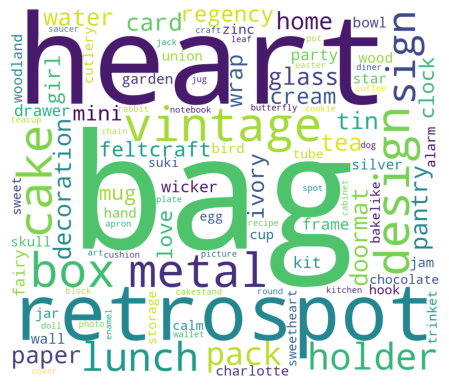

In [100]:
# k - 词 
# v - 出现次数

counts = {}     
#数组对象  用来接收需要传递给词云的内容
chiyun = []
for word in contexts_n:
     # == 1 单个词语不计算在内
    if  len(word) < 3 :  
        continue
    else:
         # 遍历所有词语，每出现一次其对应的值加 1
        counts[word] = counts.get(word, 0) + 1   

#将键值对转换成列表
items = list(counts.items())

# 根据词语出现的次数进行从大到小排序
items.sort(key=lambda x: x[1], reverse=True)

#列标题 format
print("{0:<5}{1:<8}{2:<5}".format('序号','词语', '频率'))

for i in range(100):
    word, count = items[i]
    print("{0:<5}{1:<8}{2:>5}".format(i+1,word,count))
    chiyun.append(word)

#join 函数 用斜杆拼接词组
text_cut  =  ' '.join(chiyun)
wordcloud = WordCloud(background_color='white', width=1000, height=860, margin=2).generate(text_cut)
# 显示图片 
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [101]:
t = [i[0] for i in items]
t

['bag',
 'heart',
 'retrospot',
 'vintage',
 'design',
 'box',
 'cake',
 'metal',
 'lunch',
 'sign',
 'holder',
 'pack',
 'paper',
 'card',
 'tea',
 'glass',
 'decoration',
 'home',
 'water',
 'pantry',
 'tin',
 'doormat',
 'regency',
 'ivory',
 'cream',
 'wrap',
 'feltcraft',
 'girl',
 'mug',
 'mini',
 'love',
 'clock',
 'party',
 'wicker',
 'kit',
 'frame',
 'fairy',
 'drawer',
 'garden',
 'woodland',
 'silver',
 'bowl',
 'wall',
 'star',
 'wood',
 'charlotte',
 'bird',
 'hand',
 'union',
 'skull',
 'zinc',
 'cutlery',
 'jam',
 'jar',
 'cup',
 'alarm',
 'chocolate',
 'bakelike',
 'egg',
 'sweetheart',
 'suki',
 'sweet',
 'storage',
 'trinket',
 'tube',
 'hook',
 'calm',
 'butterfly',
 'craft',
 'cover',
 'jack',
 'enamel',
 'chain',
 'kitchen',
 'round',
 'leaf',
 'photo',
 'cushion',
 'dog',
 'spot',
 'coffee',
 'cookie',
 'plate',
 'apron',
 'diner',
 'saucer',
 'wallet',
 'teacup',
 'art',
 'cakestand',
 'notebook',
 'block',
 'doll',
 'jug',
 'cabinet',
 'rabbit',
 'recipe',
 'ea

#### 按词的出现频率绘图

注意：在绘制的图中 有一些名词在很多种分类中都能出现 比如sign、set...还有一些表示颜色的词  
为了使后续的分类更加准确 这里准备使用tf-idf对名词进行提取

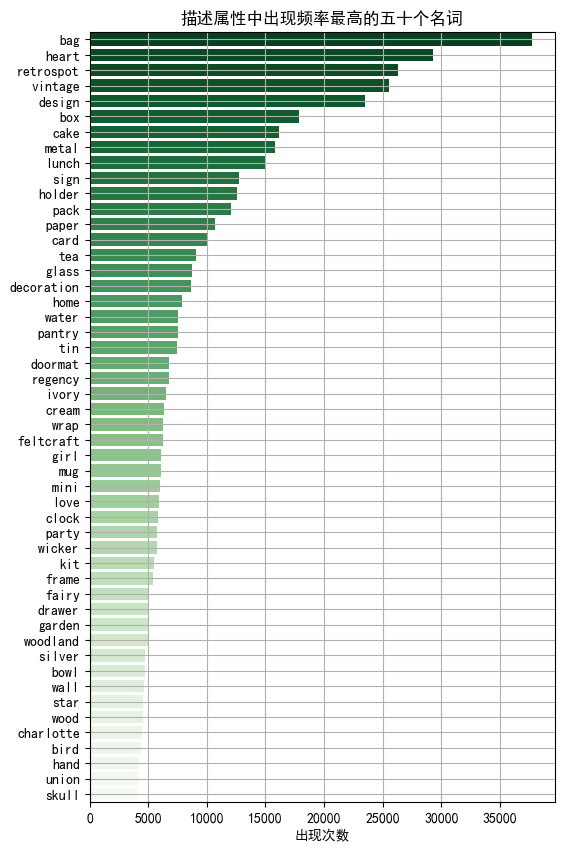

In [102]:
plt.figure(figsize=(6,10))

ax = plt.gca()

plt.rc('font', weight='normal')
sns.barplot(y=[i[0] for i in items][0:50],x=[i[1] for i in items][0:50],palette='Greens_r')
plt.title('描述属性中出现频率最高的五十个名词')
plt.xlabel('出现次数')
ax.xaxis.grid()
ax.yaxis.grid()

#### tf-idf剔除无区分性的词

<img src='./td-idf解释.png'>

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer

colors = ['red','blue','yellow','pink','purple','green','black','white']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([i for i in data.Description.unique()])

tfidf = dict(zip([i for i in vectorizer.get_feature_names_out() if len(i) >= 3 and i not in colors], vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tdidf']).from_dict(
    dict(tfidf), orient='index'
)
tfidf.columns = ['tfidf']

In [118]:
tfidf.sort_values(by='tfidf',ascending=True).head(50)

,tfidf
sleeping,3.442476
postcard,3.519556
pannetone,3.786095
horse,3.790288
box,3.833213
russian,3.954291
basket,4.156613
gymkhanna,4.162693
cluster,4.258613
bullet,4.342578


从结果上看分数为6到7之间的数有很多包括颜色在内不具有区分意义的词  
故去掉分数低于7的名词

In [164]:
value_cleaned = tfidf.loc[tfidf['tfidf'] >= 7].index.to_list()[1:]
len(value_cleaned)

855

存一下最后的结果不然内存清了就寄了

In [165]:
with open('value_cleaned.txt', 'w') as f:
    for item in value_cleaned:
        f.write(str(item) + '\n')

读

In [6]:
with open('value_cleaned.txt', 'r') as f:
    value_cleaned = []
    for line in f:
        value_cleaned.append(line.strip())

## 3.利用Kmeans做分类

In [4]:
data = pd.read_csv('./data_cleaned.csv')

构建矩阵matrix  
x代表每一条Description  
y代表刚刚整理出来的value_cleaned  
如果Description[i]中含有value_cleaned[j]  
则matrix[i][j] == 1

In [7]:
products = data['Description'].unique()
X = pd.DataFrame()
Y = data[['Description','UnitPrice']].groupby(by='Description').aggregate('mean').reset_index()

for c in value_cleaned:
    X.loc[:,c] = list(map(lambda x : int(c in x), products))

D:\Temp\ipykernel_24968\1873788151.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:,c] = list(map(lambda x : int(c in x), products))
D:\Temp\ipykernel_24968\1873788151.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:,c] = list(map(lambda x : int(c in x), products))
D:\Temp\ipykernel_24968\1873788151.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

增加属性：商品单价的分箱

In [172]:
data.UnitPrice.describe()

count    397327.000000
mean          3.118331
std          22.113310
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

In [8]:
threshold = [0,1,2,5,10,8143]
labels = []

prefix = "unitprice_"
for i in range(len(threshold)-1):
    labels.append(f'{prefix}{i}')

cut = pd.cut(Y.UnitPrice,bins=threshold,labels=labels)

for i,j in enumerate(cut.values):
    X.loc[i,j] = 1

X.fillna(0,inplace=True)
X.head()

D:\Temp\ipykernel_24968\4138300936.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[i,j] = 1
D:\Temp\ipykernel_24968\4138300936.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[i,j] = 1
D:\Temp\ipykernel_24968\4138300936.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[i

,abstract,adult,ahoy,airline,album,allium,alphabet,alpine,aluminium,amber,...,wood,wool,word,work,world,unitprice_2,unitprice_1,unitprice_4,unitprice_3,unitprice_0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1.0,0.0,0.0,0.0,0.0


聚类

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_scores = []
n = []

matrix = X.values
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)

    silhouette_scores.append(silhouette_avg)
    n.append(n_clusters)

    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.12865074814319905
For n_clusters = 4 The average silhouette_score is : 0.15369675198978086
For n_clusters = 5 The average silhouette_score is : 0.1577167481204889
For n_clusters = 6 The average silhouette_score is : 0.16556215906691898
For n_clusters = 7 The average silhouette_score is : 0.1300564686975523
For n_clusters = 8 The average silhouette_score is : 0.14878782766030182
For n_clusters = 9 The average silhouette_score is : 0.14750443233353994


拐点大概在n_cluster = 5  
分成五类

Text(0.5, 0, 'n_clusters数量')

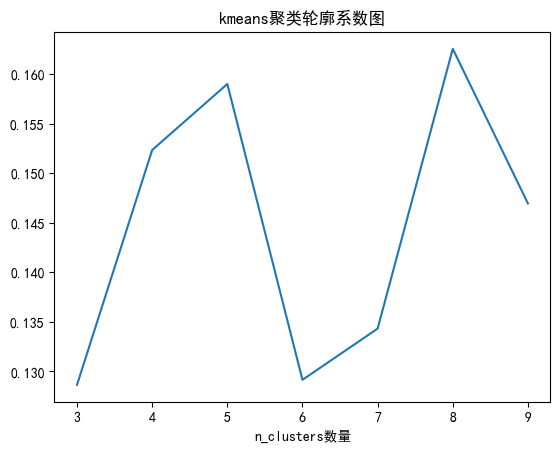

In [71]:
sns.lineplot(x=n,y=silhouette_scores)
plt.title('kmeans聚类轮廓系数图')
plt.xlabel('n_clusters数量')

In [11]:
kmeans = KMeans(init='k-means++', n_clusters = 5, n_init=30)
kmeans.fit(matrix)
clusters = kmeans.predict(matrix)

clusters

array([1, 4, 4, ..., 0, 2, 1])

In [12]:
df_context = pd.concat([Y.iloc[:,0],pd.DataFrame(clusters, columns=['product_class'])], axis=1)
df_context.value_counts('product_class')

product_class
1    1233
4     968
0     916
2     600
3     158
Name: count, dtype: int64

In [83]:
df_context.loc[df_context['product_class'] == 1]

,Description,product_class
6,oval wall mirror diamante,1
10,toadstool bedside light,1
30,15cm christmas glass ball 20 lights,1
43,3 drawer antique white wood cabinet,1
47,3 hook photo shelf antique white,1
...,...,...
3852,zinc box sign home,1
3856,zinc heart lattice 2 wall planter,1
3860,zinc heart lattice tray oval,1
3862,zinc herb garden container,1


词云展示  
在value_cleaned里面存在的才在词云里面展示

In [124]:
len(value_cleaned)

851

IndexError: list index out of range

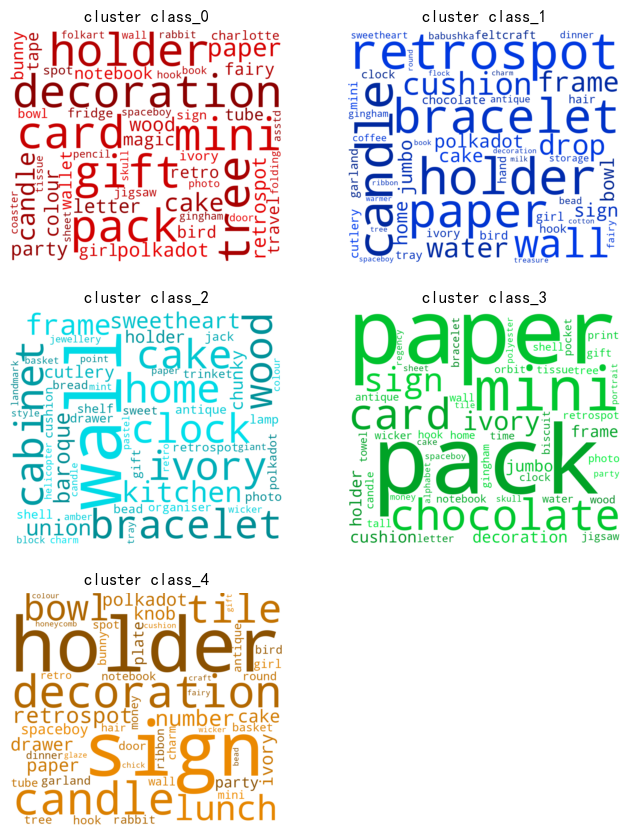

In [39]:
fig = plt.figure(1, figsize=(8,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]

df_context.Description = df_context['Description'].str.strip()
except_ = ['red','design','heart','vintage','box']
value_cleaned = [i for i in value_cleaned if i not in except_]

def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

for n in range(n_clusters - 1):
    cs = df_context.loc[df_context['product_class'] == n].Description.str.split(' ').to_list()
    contexts_n = [j for i in cs for j in i]

    count_dict = {}

    counts = {}     
#数组对象  用来接收需要传递给词云的内容
    chiyun = []
    for word in contexts_n:
     # == 1 单个词语不计算在内
        if word in value_cleaned :  
            # 遍历所有词语，每出现一次其对应的值加 1
            counts[word] = counts.get(word, 0) + 1   

    #将键值对转换成列表
    items = list(counts.items())

    # 根据词语出现的次数进行从大到小排序
    items.sort(key=lambda x: x[1], reverse=True)

    for i in range(50):
        word, count = items[i]
        chiyun.append(word)

    #join 函数 用斜杆拼接词组
    text_cut  =  ' '.join(chiyun)
    tone = color[n]
    wordcloud = WordCloud(background_color='white', width=1000, height=860,color_func = random_color_func, margin=2).generate(text_cut)
    # 显示图片 
    ax1 = fig.add_subplot(4,2,n + 1)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster class_{}'.format(n))

In [13]:
Y.Description

0          4 purple flock dinner candles
1          50's christmas gift bag large
2                      dolly girl beaker
3            i love london mini backpack
4            i love london mini rucksack
                      ...               
3870     zinc t-light holder stars small
3871      zinc top  2 door wooden shelf 
3872    zinc willie winkie  candle stick
3873         zinc wire kitchen organiser
3874    zinc wire sweetheart letter tray
Name: Description, Length: 3875, dtype: object

## 4.用户画像分析

#### 4.1数据处理

In [44]:
df_context.head()

,Description,product_class
0,4 purple flock dinner candles,1
1,50's christmas gift bag large,4
2,dolly girl beaker,4
3,i love london mini backpack,1
4,i love london mini rucksack,1


In [54]:
customer = pd.merge(data,df_context,how='inner',on='Description')
customer.product_class.value_counts()

product_class
1    103033
4     85938
0     65638
2     42096
3     16690
Name: count, dtype: int64

In [65]:
customer['totalprice'] = customer['Quantity'] * customer['UnitPrice']

6

In [69]:
for i in customer.index:
    tag = f'tag_{customer.iloc[i].product_class}'
    customer.loc[i,tag] = customer.loc[i,'totalprice']

customer
customer.fillna(0,inplace=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,product_class,totalprice,tag_1,tag_2,tag_4,tag_0,tag_3
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,1,15.30,15.30,NaN,NaN,NaN,NaN
1,536373,85123A,white hanging heart t-light holder,6,2010-12-01 09:02:00,2.55,17850,United Kingdom,1,15.30,15.30,NaN,NaN,NaN,NaN
2,536375,85123A,white hanging heart t-light holder,6,2010-12-01 09:32:00,2.55,17850,United Kingdom,1,15.30,15.30,NaN,NaN,NaN,NaN
3,536390,85123A,white hanging heart t-light holder,64,2010-12-01 10:19:00,2.55,17511,United Kingdom,1,163.20,163.20,NaN,NaN,NaN,NaN
4,536394,85123A,white hanging heart t-light holder,32,2010-12-01 10:39:00,2.55,13408,United Kingdom,1,81.60,81.60,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313390,581404,85123A,cream hanging heart t-light holder,4,2011-12-08 13:47:00,2.95,13680,United Kingdom,1,11.80,11.80,NaN,NaN,NaN,NaN
313391,581412,85123A,cream hanging heart t-light holder,4,2011-12-08 14:38:00,2.95,14415,United Kingdom,1,11.80,11.80,NaN,NaN,NaN,NaN
313392,581432,85123A,cream hanging heart t-light holder,32,2011-12-08 15:51:00,2.55,13798,United Kingdom,1,81.60,81.60,NaN,NaN,NaN,NaN
313393,581538,85123A,cream hanging heart t-light holder,1,2011-12-09 11:34:00,2.95,14446,United Kingdom,1,2.95,2.95,NaN,NaN,NaN,NaN


切分数据集 后续进行预测

In [110]:
customer_after_groupby = customer.groupby(by=['InvoiceNo','CustomerID']).agg(
    {
        'tag_0':sum,'tag_1':sum,'tag_2':sum,'tag_3':sum,'tag_4':sum,'totalprice':sum,
        'InvoiceDate':'mean'
    }
).reset_index()

train = customer_after_groupby.loc[customer_after_groupby['InvoiceDate'] <= '2011-10-01']
test = customer_after_groupby.loc[customer_after_groupby['InvoiceDate'] > '2011-10-01']

In [133]:
transactions_per_user=customer_after_groupby.groupby(by=['CustomerID'])['totalprice'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'tag_{}'.format(i)
    transactions_per_user.loc[:,col] = customer_after_groupby.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
customer_after_groupby.groupby(by=['CustomerID'])['tag_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,tag_0,tag_1,tag_2,tag_3,tag_4
0,12346,1,77183.60,77183.6,77183.600000,77183.60,0.000000,0.000000,0.000000,0.000000,100.000000
1,12347,7,178.14,975.9,481.737143,3372.16,8.946195,50.298029,11.309962,3.622604,25.823211
2,12348,4,40.00,788.4,269.390000,1077.56,42.091392,0.000000,33.408813,0.000000,24.499796
3,12349,1,1354.20,1354.2,1354.200000,1354.20,5.081967,16.552208,50.335992,1.462118,26.567715
4,12350,1,216.80,216.8,216.800000,216.80,18.035055,8.164207,18.450185,11.623616,43.726937


In [13]:
transactions_per_user = transactions_per_user.iloc[1:]
transactions_per_user.to_csv('./transactions_per_user.csv',index=False)
transactions_per_user.head()

,CustomerID,count,min,max,mean,sum,tag_0,tag_1,tag_2,tag_3,tag_4
1,12347,7,178.14,975.9,481.737143,3372.16,8.946195,50.298029,11.309962,3.622604,25.823211
2,12348,4,40.00,788.4,269.390000,1077.56,42.091392,0.000000,33.408813,0.000000,24.499796
3,12349,1,1354.20,1354.2,1354.200000,1354.20,5.081967,16.552208,50.335992,1.462118,26.567715
4,12350,1,216.80,216.8,216.800000,216.80,18.035055,8.164207,18.450185,11.623616,43.726937
5,12352,8,72.78,840.3,270.192500,2161.54,0.471886,15.501911,65.754046,1.832027,16.440131


#### 4.2开始画像

In [14]:
transactions_per_user = pd.read_csv('./transactions_per_user.csv')
transactions_per_user

,CustomerID,count,min,max,mean,sum,tag_0,tag_1,tag_2,tag_3,tag_4
0,12347,7,178.14,975.90,481.737143,3372.16,8.946195,50.298029,11.309962,3.622604,25.823211
1,12348,4,40.00,788.40,269.390000,1077.56,42.091392,0.000000,33.408813,0.000000,24.499796
2,12349,1,1354.20,1354.20,1354.200000,1354.20,5.081967,16.552208,50.335992,1.462118,26.567715
3,12350,1,216.80,216.80,216.800000,216.80,18.035055,8.164207,18.450185,11.623616,43.726937
4,12352,8,72.78,840.30,270.192500,2161.54,0.471886,15.501911,65.754046,1.832027,16.440131
...,...,...,...,...,...,...,...,...,...,...,...
4321,18280,1,130.20,130.20,130.200000,130.20,0.000000,52.803379,47.196621,0.000000,0.000000
4322,18281,1,47.37,47.37,47.370000,47.37,21.279291,32.298923,35.782141,10.639645,0.000000
4323,18282,2,47.14,100.21,73.675000,147.35,17.373600,32.439769,34.611469,0.000000,15.575161
4324,18283,16,1.95,220.06,98.775625,1580.41,17.821325,41.077948,2.553135,8.192178,30.355414


In [20]:
transactions_per_user.fillna(0,inplace=True)

In [21]:
matrix = transactions_per_user.iloc[:,1:].values

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_scores = []
n = []

for n_clusters in range(6,20):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)

    silhouette_scores.append(silhouette_avg)
    n.append(n_clusters)

    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 6 The average silhouette_score is : 0.8262944925382683
For n_clusters = 7 The average silhouette_score is : 0.7279145591502072
For n_clusters = 8 The average silhouette_score is : 0.6682018921634877
For n_clusters = 9 The average silhouette_score is : 0.6684841224522035
For n_clusters = 10 The average silhouette_score is : 0.6119988230424577
For n_clusters = 11 The average silhouette_score is : 0.6079996540227383
For n_clusters = 12 The average silhouette_score is : 0.5985703022302175
For n_clusters = 13 The average silhouette_score is : 0.5635078638937373
For n_clusters = 14 The average silhouette_score is : 0.563571040248477
For n_clusters = 15 The average silhouette_score is : 0.5674958012318233
For n_clusters = 16 The average silhouette_score is : 0.5675257869771856
For n_clusters = 17 The average silhouette_score is : 0.4817347366776283
For n_clusters = 18 The average silhouette_score is : 0.49181361674021346
For n_clusters = 19 The average silhouette_score is : 0

Text(0.5, 0, 'n_clusters数量')

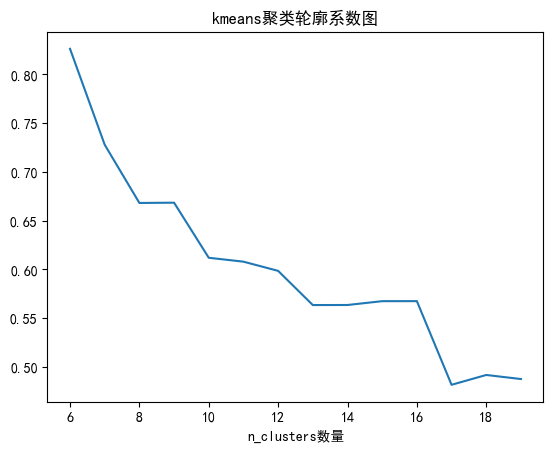

In [24]:
sns.lineplot(x=n,y=silhouette_scores)
plt.title('kmeans聚类轮廓系数图')
plt.xlabel('n_clusters数量')

取n = 13

In [25]:
kmeans = KMeans(init='k-means++', n_clusters = 13, n_init=30)
kmeans.fit(matrix)
clusters = kmeans.predict(matrix)

In [31]:
data = pd.concat([transactions_per_user,pd.DataFrame(clusters,columns=['customer_class'])],axis=1)

In [33]:
customer_graph = data.groupby('customer_class').agg('mean').reset_index().drop(columns='CustomerID')
customer_graph

,customer_class,count,min,max,mean,sum,tag_0,tag_1,tag_2,tag_3,tag_4
0,0,5.204145,241.363751,600.921306,402.083168,1545.189969,12.148343,37.379885,21.573024,4.924502,23.974246
1,1,46.000000,34.560000,27734.400000,3714.643696,170873.610000,5.889897,64.444890,8.300275,3.377725,17.987213
2,2,6.333333,1617.500000,24796.246667,9622.541709,37975.486667,4.582497,24.128320,40.934580,6.013064,24.341539
3,3,2.000000,2.900000,168469.600000,84236.250000,168472.500000,0.000000,99.998279,0.000000,0.000979,0.000742
4,4,44.100000,40.377000,5956.351000,1541.563902,47676.659000,11.065216,40.865200,25.632558,3.374926,19.062100
5,5,23.116279,169.720698,2052.623023,824.501907,12604.844651,9.272162,38.250226,27.021561,5.257855,20.198196
6,6,46.250000,79.286875,3699.646875,1039.230440,25400.475000,8.923272,48.583054,19.704491,5.359173,17.430009
7,7,199.000000,1.450000,2889.020000,579.025025,115225.980000,11.071965,35.753525,27.845951,5.142764,20.185795
8,8,15.820000,249.628700,1445.114300,717.893484,6909.307800,10.156091,39.525457,26.008725,4.731510,19.578217
9,9,41.500000,50.080000,10643.055000,2379.892271,82017.407500,7.315549,46.689647,19.886855,5.645969,20.461979


四行四列极坐标图

In [49]:
courses

Index(['count', 'min', 'max', 'mean', 'sum', 'tag_0', 'tag_1', 'tag_2',
       'tag_3', 'tag_4', 'customer_class'],
      dtype='object')

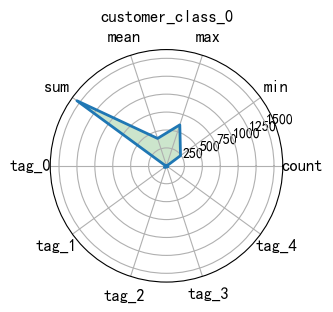

In [61]:
courses = customer_graph.columns[1:]

i = 0
plt.figure(figsize=(3,4))
scores = customer_graph.iloc[i,1:].values.tolist()
dataLength = len(scores)#数据长度

#angles数组把圆周等分为dataLength份
angles = np.linspace(0,2*np.pi,dataLength,endpoint=False)
scores.append(scores[0])
angless = np.append(angles,angles[0]) #闭合

#绘制雷达图
plt.polar(angless, #设置角度
scores, #设置各个角度上的数据
linewidth=2) #设置线宽

#设置角度网络标签
plt.thetagrids(angles*180/np.pi,courses,fontproperties='simhei',fontsize=12,color='k')
plt.title(f'customer_class_{i}')
#填充雷达图内部
plt.fill(angless,scores,facecolor='g',alpha=0.2)
plt.show()
plt.savefig(f'./customer_class_{i}.jpg')